In [3]:
import os
from collections import defaultdict
import numpy as np
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
from math import log
import math

In [4]:
filenames = []
parts = ["./data/part"+str(i) for i in range(1,11)]
for part in parts:
    filenames = filenames + (os.listdir(part))

In [5]:
spams = list(filter(lambda x: x.find("spm") != -1, filenames))
legits = list(filter(lambda x: x.find("legit") != -1, filenames))

In [6]:
def read_files(diretories, n, alpha):
    words = defaultdict(lambda:[0,0])
    counter = [0,0]
    for directory in diretories:
        for file in os.listdir(directory):
            f = open(directory+"/"+file, "r")
            text = f.readline().split()[1:] + [0] * n
            f.readline()
            checker = set()
            text += f.readline().split() + [0]*n
            text = list(map(int,text))
            pos = 0 if file.find("legit")==-1 else 1
            
            counter[pos]+=1
            for i in range(1,n+1):
                for j in range(len(text)):
                    if not tuple(text[j:j+i]) in checker:
                        checker.add(tuple(text[j:j+i]))
                        words[tuple(text[j:j+i])][pos]+=1
   # words = defaultdict(lambda:[0,0],filter(lambda elem: elem[1][0]+elem[1][1] > 60,words.items()))
    return counter,words
def read_file_test(diretories, n, alpha):
    textes = []
    classes = []
    for directory in diretories:
        for file in os.listdir(directory):
            f = open(directory+"/"+file, "r")
            text = f.readline().split()[1:] + [0] * n
            f.readline()
            checker = set()
            text += f.readline().split() + [0]*n
            text = list(map(int,text))
            label = 0 if file.find("legit")==-1 else 1
            textes.append(text)
            classes.append(label)
    return textes,classes

In [7]:
def predict(counter,model,l, text, n):
    checker = set()
    ans = [1.0,1.0]
    for i in range(1,n+1):
        for j in range(len(text)):
            word = tuple(text[j:j+i])
            if(not word in checker and word in model):
                checker.add(word)
                ans[0] *= model[word][0]
                ans[1] *= model[word][1]
    for key in model:
        if not key in checker:
            ans[0] *= (1-model[key][0])
            ans[1] *= (1-model[key][1])
    ans[0] *= l[0] * (counter[0]/(sum(counter)))
    ans[1] *= l[1] * (counter[1]/(sum(counter)))
    if(ans[0]==0 or ans[1]==0):
        print("ZERO")
    return 0 if ans[0] > ans[1] else 1 

In [8]:
def predict_prob(counter,model,l, text, n):
    checker = set()
    ans = [0,0]
    for i in range(1,n+1):
        for j in range(len(text)):
            word = tuple(text[j:j+i])
            if(not word in checker and word in model):
                checker.add(word)
                ans[0] +=log(model[word][0])
                ans[1] +=log(model[word][1])
    for key in model:
        if not key in checker:
            ans[0] += log(1-model[key][0])
            ans[1] += log(1-model[key][1])
    ans[0] += l[0] * log(counter[0]/(sum(counter)))
    ans[1] += l[1] * log(counter[1]/(sum(counter)))
    s = ans[0]+ans[1]
    ans[0]/=s
    ans[1]/=s
    return 1-(1-ans[0]+ans[1])/2
    

In [9]:
def remover(counter,words, texts, labels,n):
    for label,text in zip(labels,texts):
        counter[label]-=1
        checker=set()
        for i in range(1,n+1):
            for j in range(len(text)):
                if not tuple(text[j:j+i]) in checker:
                    checker.add(tuple(text[j:j+i]))
                    words[tuple(text[j:j+i])][label]-=1
    return counter,words

In [10]:
def adder(counter,words, texts, labels,n):
    for label,text in zip(labels,texts):
        checker=set()
        counter[label]+=1
        for i in range(1,n+1):
            for j in range(len(text)):
                if not tuple(text[j:j+i]) in checker:
                    checker.add(tuple(text[j:j+i]))
                    words[tuple(text[j:j+i])][label]+=1
    return counter,words

In [11]:
def score(actual,predicted):        
    return sum([1 if A==B else 0 for A,B in zip(actual,predicted)])/len(actual)

In [12]:
def calcErrors(actual,predicted):
    TP,TN,FP,FN = 0,0,0,0
    for truth, predict in zip(actual,predicted):
        if(truth==0):
            if(predict==0):
                TP+=1
            else:
                FN+=1
        else:
            if(predict==1):
                TN+=1
            else:
                FP+=1
    return np.asarray([TP,TN,FP,FN])

In [13]:
def make_model(alpha,words,counter):
    for word in words:
        words[word][0] = (words[word][0] + alpha)/(counter[0] + alpha*2)
        words[word][1] = (words[word][1] + alpha)/(counter[1] + alpha*2)
    return words
def cross_validation(n,alpha,l_legit = 1, extra=False):
    lscore = 0
    errors = np.asarray([0,0,0,0])
    for i in range(10):
        #print("start read")
        texts, labels = read_file_test(parts[i:i+1],n,alpha)
        counter,words = read_files(parts[0:i]+parts[i+1:10],n,alpha)
        #print("end read")
        model = make_model(alpha,words,counter)
        labels_p = [predict(counter,model,[1,l_legit],text,n) for text in texts]
        lscore += score(labels,labels_p)
        errors = errors + calcErrors(labels,labels_p)
        #print(len(words))
        #print(score(labels,labels_p))
    return lscore / 10 if extra else lscore / 10, errors

In [14]:
def cross_validation_pr(n,alpha,l_legit = 1, l_spam=1,extra=False):
    lscore = 0
    errors = np.asarray([0,0,0,0])
    for i in range(10):
        #print("start read")
        texts, labels = read_file_test(parts[i:i+1],n,alpha)
        counter,words = read_files(parts[0:i]+parts[i+1:10],n,alpha)
        #print("end read")
        model = make_model(alpha,words,counter)
        labels_p = [0 if predict_prob(counter,model,[l_spam,l_legit],text,n)<0.5 else 1 for text in texts]
        lscore += score(labels,labels_p)
        errors = errors + calcErrors(labels,labels_p)
        #print(len(words))
        #print(score(labels,labels_p))
    return lscore / 10 if extra else lscore / 10, errors

In [15]:
def cross_validation_fast(n,alpha,l_legit = 1, extra=False):
    lscore = 0
    errors = np.asarray([0,0,0,0])
    counter,words = read_files(parts,n,alpha)
    for i in range(10):
        #print("start read")
        texts, labels = read_file_test(parts[i:i+1],n,alpha)
        counter, words = remover(counter,words,texts,labels,n)
        #print("end read")
        model = make_model(alpha,dict(words),counter)
        labels_p = [predict(counter,model,[1,l_legit],text,n) for text in texts]
        lscore += score(labels,labels_p)
        errors = errors + calcErrors(labels,labels_p)
        counter, words = adder(counter,words,texts,labels,n)
        #print(len(words))
        #print(score(labels,labels_p))
    return lscore / 10 if extra else lscore / 10, errors

In [36]:
for n in range(1,4):
    for alpha in [10**(-i) for i in range(1,10,2)]:
        print(n, alpha, cross_validation(n,alpha))

1 0.1 (0.824770642201835, array([296, 603,   7, 184]))
1 0.001 (0.8284403669724771, array([298, 605,   5, 182]))
1 1e-05 (0.8302752293577982, array([299, 606,   4, 181]))
1 1e-07 (0.824770642201835, array([292, 607,   3, 188]))
1 1e-09 (0.8229357798165138, array([289, 608,   2, 191]))
2 0.1 (0.5642201834862386, array([  5, 610,   0, 475]))
2 0.001 (0.5871559633027523, array([ 30, 610,   0, 450]))
2 1e-05 (0.6091743119266055, array([ 54, 610,   0, 426]))
2 1e-07 (0.6137614678899082, array([ 59, 610,   0, 421]))
2 1e-09 (0.6174311926605505, array([ 63, 610,   0, 417]))
3 0.1 (0.5596330275229358, array([  0, 610,   0, 480]))
3 0.001 (0.5660550458715596, array([  8, 609,   1, 472]))
3 1e-05 (0.571559633027523, array([ 14, 609,   1, 466]))
3 1e-07 (0.5733944954128442, array([ 16, 609,   1, 464]))
3 1e-09 (0.5788990825688074, array([ 21, 610,   0, 459]))


In [219]:
texts,labels = read_file_test(parts[0:0+1],1,1)
q,w = remover(q,w,texts,labels,1)

In [187]:
cross_validation_pr(1,10**(-15))

ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO
ZERO


KeyboardInterrupt: 

In [23]:
t = []

In [24]:
def draw_roc(n=1, alpha = 1e-5,l_legit=1):
    counter,words = read_files(parts,n,alpha)
    model = make_model(alpha,words,counter)
    texts, labels = read_file_test(parts,n,alpha)
    labels_p = [predict_prob(counter,model,[1,l_legit],text,n) for text in texts]
    fpr,tpr,_ = roc_curve(labels,labels_p)
    t = labels_p
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()

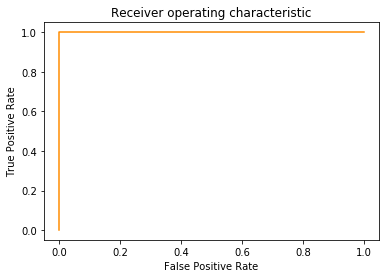

In [25]:
draw_roc()


In [28]:
n=1
alpha = 1e-5
l_legit=1
counter,words = read_files(parts,n,alpha)
model = make_model(alpha,words,counter)
texts, labels = read_file_test(parts,n,alpha)
labels_p = [predict_prob(counter,model,[1,l_legit],text,n) for text in texts]

In [36]:
accuracy_score(labels,[0 if l < 0.51 else 1 for l in [predict_prob(counter,model,[1,l_legit],text,n) for text in texts]])

1.0

In [174]:
for n in range(1,2):
    for alpha in [10**(-i) for i in range(1,10,2)]:
        print(n, alpha, cross_validation_pr(n,alpha))

1 0.1 (0.9532110091743119, array([437, 602,   8,  43]))
1 0.001 (0.9605504587155964, array([444, 603,   7,  36]))
1 1e-05 (0.9678899082568808, array([450, 605,   5,  30]))
1 1e-07 (0.9706422018348624, array([452, 606,   4,  28]))
1 1e-09 (0.9706422018348624, array([452, 606,   4,  28]))


In [37]:
cross_validation_pr(1,1,l_spam=1)

(0.9155963302752295, array([393, 605,   5,  87]))

In [38]:
cross_validation_pr(1,1e-6,l_spam=1)

(0.9678899082568808, array([450, 605,   5,  30]))

In [171]:
sres=[]
for l_legit in [10**(i/2) for i in range(10)]:
    sres.append(cross_validation_pr(1,10e-9,l_spam=l_legit))
    print(sres[len(sres)-1])

(0.9706422018348624, array([452, 606,   4,  28]))
(0.9706422018348624, array([452, 606,   4,  28]))
(0.9669724770642205, array([447, 607,   3,  33]))
(0.9513761467889911, array([429, 608,   2,  51]))
(0.9119266055045874, array([386, 608,   2,  94]))
(0.7880733944954128, array([249, 610,   0, 231]))
(0.6587155963302752, array([108, 610,   0, 372]))
(0.5807339449541284, array([ 23, 610,   0, 457]))
(0.5596330275229358, array([  0, 610,   0, 480]))
(0.5596330275229358, array([  0, 610,   0, 480]))


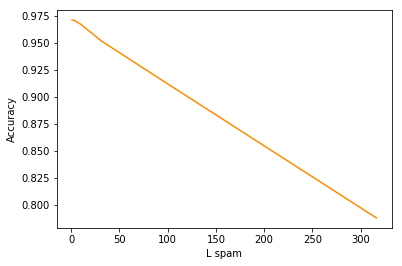

In [173]:
plt.figure()
plt.plot([10**(i/2) for i in range(6)], [v[0] for v in sres[0:6]], color='darkorange')
plt.xlabel('L spam')
plt.ylabel('Accuracy')
plt.show()

In [175]:
model

defaultdict(<function __main__.read_files.<locals>.<lambda>()>,
            {(14486,): [0.012500020312499152, 0.003278704810534269],
             (0,): [0.9999999791666675, 0.999999983606558],
             (80,): [0.9104166495659729, 0.9770491646869127],
             (196,): [0.40416667065972206, 0.6114754061811343],
             (64,): [0.5166666659722222, 0.47213114845471643],
             (1896,): [0.28333334236111074, 0.0967213246976615],
             (8962,): [0.4750000010416666, 0.16885246987368954],
             (14328,): [0.48125000078124996, 0.20819673087879573],
             (2130,): [0.9041666498263895, 0.9278688384305299],
             (16502,): [0.9145833160590284, 0.9590163783929057],
             (9211,): [0.06875001796874926, 0.10491804574039196],
             (84,): [0.9770833134548619, 0.9983606393980119],
             (4339,): [0.6645833264756946, 0.5967213083042194],
             (180,): [0.8708333178819451, 0.8688524469228707],
             (16926,): [0.26041667664

In [184]:
i=0
a0=1
a1=1
b1=0
b2=0
for word in model:
    a0*=model[word][0]
    a1*=model[word][1]
    b1+=log(model[word][0])
    b2+=log(model[word][1])
    i+=1
    if((i % 100) == 0):
        print(i)
        print(a0,a1,b1,b2)
        print(a0>a1)
        print(b1>b2)

100
6.0895631857978164e-68 7.73338773059293e-108 -154.76920997091577 -246.63364301924912
True
True
200
9.626215617868542e-188 1.5e-323 -430.6215073127211 -743.2634776168363
True
True
300
1.0843886389881513e-308 0.0 -709.1151922803504 -1244.5137135635327
True
True
400
0.0 0.0 -1018.1000863935371 -1766.8815455304143
False
True
500
0.0 0.0 -1330.37317205156 -2480.2131362946534
False
True
600
0.0 0.0 -2169.0932906773064 -2877.453446866103
False
True
700
0.0 0.0 -3163.567681523949 -3304.065329920071
False
True
800
0.0 0.0 -3665.618905400157 -3806.1003482401416
False
True
900
0.0 0.0 -4003.7089835820702 -4419.003445691805
False
True
1000
0.0 0.0 -4328.086420002077 -5128.686647819476
False
True
1100
0.0 0.0 -4625.514690526353 -5822.211660761759
False
True
1200
0.0 0.0 -4994.504122231089 -6676.951469862274
False
True
1300
0.0 0.0 -5309.293247371284 -7363.617741792942
False
True
1400
0.0 0.0 -5654.815499153031 -8429.586667128191
False
True
1500
0.0 0.0 -6185.636279716878 -9081.747043790454
Fals

False
23400
0.0 0.0 -259225.9453100911 -214889.9547832698
False
False
23500
0.0 0.0 -260695.2801490562 -215818.4299267122
False
False
23600
0.0 0.0 -261667.47933648835 -217229.34975405884
False
False
23700
0.0 0.0 -262511.6499494452 -218791.72949025195
False
False
23800
0.0 0.0 -264060.88219448406 -219648.64213092168
False
False
23900
0.0 0.0 -265264.7263755756 -220853.42772552196
False
False
24000
0.0 0.0 -266849.1905691898 -221677.5933075996
False
False
24100
0.0 0.0 -267822.0828988025 -223113.3307536787
False
False
24200
0.0 0.0 -269015.1072866097 -224330.32242592447
False
False
24300
0.0 0.0 -270115.33504851704 -225627.21150424404
False
False
24400
0.0 0.0 -271435.0017264383 -226717.5608863758
False
False
24500
0.0 0.0 -273088.54353284196 -227438.80319144984
False
False
24600
0.0 0.0 -274154.9256305352 -228782.43715380965
False
False
24700
0.0 0.0 -275405.51469566696 -229941.86414873088
False
False


In [181]:
1%100

1